# 0. Import packages

In [19]:
import torch
from torch import nn
from transformers import AutoConfig, AutoTokenizer, AutoModel
import numpy as np

# 1. Summary
- Instead of one attention, we split Q, K, V into multiple smaller sets called “heads.”
- Each head learns to focus on different types of relationships in the sequence.
- The results from all heads are concatenated and combined to form the final output.

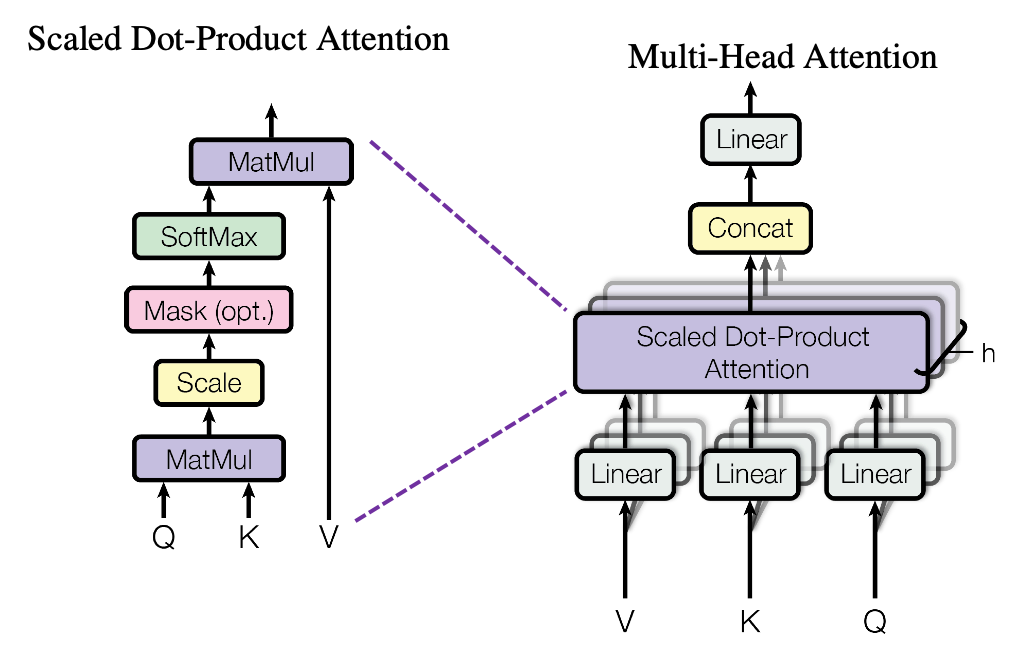

In [2]:
from IPython.display import Image
Image(filename="Images/mha.png", width=600)

## Scaled dot product attention

In [23]:
def scaled_dot_product_attention(query, key, value):
    dim_k = key.size(-1)

    attn_scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(dim_k)
    attn_weights = torch.softmax(attn_scores, dim=-1)
    attn_outputs = torch.matmul(attn_weights, value)

    return attn_outputs

## Attention Head

Normally, we define layers in **\_\_init\_\_**, define calculation process in **forward**

In [6]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        # learnable parameters
        self.Wq = nn.Linear(embed_dim, head_dim)
        self.Wk = nn.Linear(embed_dim, head_dim)
        self.Wv = nn.Linear(embed_dim, head_dim)
    
    def forward(self, hidden_states):
        # project
        q = self.Wq(hidden_states)
        k = self.Wk(hidden_states)
        v = self.Wv(hidden_states)
        
        attn_outputs = scaled_dot_product_attention(q, k, v)
        return attn_outputs

## Multi Head Attention

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads # 768/12 == 64

        self.heads = nn.ModuleList([
            AttentionHead(embed_dim, head_dim) for _ in range(num_heads)
        ])
        self.output_layer = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        # Concat
        x = torch.cat([head(hidden_state) for head in self.heads], dim=-1)
        # Linear
        x = self.output_layer(x)
        
        return x

In [22]:
model = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model)

# hyperparameters
config = AutoConfig.from_pretrained(model)

token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)

# token_embedding
text = 'The sun is so red like an apple'

# input
model_inputs = tokenizer(text, return_tensors='pt', add_special_tokens=False)

# forward of embedding module
input_embeddings = token_embedding(model_inputs['input_ids'])

mha = MultiHeadAttention(config)
mha(input_embeddings)

tensor([[[ 0.2951,  0.1875, -0.0645,  ..., -0.1494,  0.1270, -0.1895],
         [ 0.2525,  0.1274, -0.0358,  ..., -0.2201,  0.1453, -0.2579],
         [ 0.2147,  0.1034, -0.0421,  ..., -0.1871,  0.1053, -0.2434],
         ...,
         [ 0.1120,  0.1341, -0.0807,  ..., -0.1254,  0.1040, -0.2038],
         [ 0.1650,  0.0805, -0.0321,  ..., -0.2271,  0.1371, -0.2589],
         [ 0.1454,  0.1492, -0.0401,  ..., -0.1645,  0.0932, -0.2760]]],
       grad_fn=<ViewBackward0>)

In [35]:
from bertviz import head_view
from transformers import AutoModel, AutoTokenizer

# Load a pre-trained BERT model with attention outputs enabled
model_name = "bert-base-uncased"
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

sentence_a = "The cat sat on the mat."
sentence_b = "The dog lay beside the fire."

# Tokenize two sentences for input to BERT
encoded_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')

# Forward pass through BERT model, retrieving attention weights
# `attentions` is a tuple: one element per layer
attentions = model(**encoded_inputs).attentions

# Identify the position where the second sentence starts
# token_type_ids: 0 for sentence_a, 1 for sentence_b
sentence_b_start = (encoded_inputs.token_type_ids == 0).sum(dim=1)

# Convert token IDs back into readable tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(encoded_inputs.input_ids[0])

# Visualize attention for head 8 in all layers
head_view(attentions, tokens, sentence_b_start, heads=[8])

<IPython.core.display.Javascript object>